**Goal**: Create a YOLO-like dataset from the VOC-like dataset.

The HoloSelecta-FinalDataset was in VOC format, but we need it in YOLO-ready format to fine-tune a YOLO model. This code identifies also the labels of the bounding boxes. The last cell in this notebook, takes the first image and shows the bounding boxes using the YOLO datasets (verify the process was correct).


In [10]:
import xml.etree.ElementTree as ET
from pathlib import Path
from collections import Counter

In [11]:
def extract_classes_from_voc(voc_dir):
    """
    Extract all unique class names from VOC XML files
    
    Args:
        voc_dir: Directory containing XML files
        
    Returns:
        sorted list of class names
    """
    classes = set()
    class_counts = Counter()
    
    xml_files = list(Path(voc_dir).glob('*.xml'))
    
    if not xml_files:
        print(f"No XML files found in {voc_dir}")
        return []
    
    print(f"Scanning {len(xml_files)} XML files for classes...\n")
    
    for xml_file in xml_files:
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                classes.add(class_name)
                class_counts[class_name] += 1
                
        except Exception as e:
            print(f"Error reading {xml_file}: {e}")
    
    # Sort classes alphabetically
    sorted_classes = sorted(list(classes))
    
    # Print summary
    print(f"{'='*60}")
    print(f"Found {len(sorted_classes)} unique classes:")
    print(f"{'='*60}\n")
    
    for idx, cls in enumerate(sorted_classes):
        count = class_counts[cls]
        print(f"  {idx}: {cls:<30} ({count} instances)")
    
    print(f"\n{'='*60}")
    print(f"Total objects: {sum(class_counts.values())}")
    print(f"{'='*60}\n")
    
    return sorted_classes

In [12]:
def convert_voc_to_yolo_auto(voc_dir, yolo_dir, single_class=False):
    """
    Complete conversion with automatic class detection
    
    Args:
        voc_dir: Directory containing VOC XML files
        yolo_dir: Output directory for YOLO format
        single_class: If True, all objects are labeled as "object" (class_id=0)
    """
    import os
    import shutil
    
    # 1. Extract classes automatically
    print("STEP 1: Processing classes...\n")
    if single_class:
        class_names = ["object"]
        print("Using single class: 'object'")
    else:
        class_names = extract_classes_from_voc(voc_dir)
    
    if not class_names:
        print("ERROR: No classes found!")
        return None
    
    # 2. Create output directories
    print("\nSTEP 2: Creating output directories...\n")
    os.makedirs(yolo_dir, exist_ok=True)
    labels_dir = os.path.join(yolo_dir, 'labels')
    images_dir = os.path.join(yolo_dir, 'images')
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(images_dir, exist_ok=True)
    
    # 3. Convert annotations
    print("STEP 3: Converting annotations...\n")
    xml_files = list(Path(voc_dir).glob('*.xml'))
    
    converted = 0
    total_objects = 0
    
    for xml_file in xml_files:
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            # Get image dimensions
            size = root.find('size')
            img_width = int(size.find('width').text)
            img_height = int(size.find('height').text)
            
            # Prepare output file
            txt_filename = xml_file.stem + '.txt'
            txt_path = os.path.join(labels_dir, txt_filename)
            
            yolo_annotations = []
            
            # Process each object
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                
                # Use class_id = 0 if single_class, otherwise find the class_id
                if single_class:
                    class_id = 0
                else:
                    if class_name not in class_names:
                        continue
                    class_id = class_names.index(class_name)
                
                # Get bounding box
                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)
                
                # Convert to YOLO format
                x_center = ((xmin + xmax) / 2) / img_width
                y_center = ((ymin + ymax) / 2) / img_height
                width = (xmax - xmin) / img_width
                height = (ymax - ymin) / img_height
                
                yolo_annotations.append(
                    f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
                )
            
            # Write YOLO annotation file
            with open(txt_path, 'w') as f:
                f.write('\n'.join(yolo_annotations))
            
            total_objects += len(yolo_annotations)
            
            # Copy corresponding image
            img_name = xml_file.stem
            for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']:
                img_path = xml_file.parent / f"{img_name}{ext}"
                if img_path.exists():
                    shutil.copy(img_path, os.path.join(images_dir, img_path.name))
                    break
            
            converted += 1
            
            if converted % 50 == 0:
                print(f"  Processed {converted}/{len(xml_files)} files...")
                
        except Exception as e:
            print(f"  Error processing {xml_file.name}: {e}")
    
    # 4. Save class names
    print("\nSTEP 4: Saving class information...\n")
    classes_file = os.path.join(yolo_dir, 'classes.txt')
    with open(classes_file, 'w') as f:
        f.write('\n'.join(class_names))
    
    # Also save as YAML for YOLOv5/v8
    yaml_file = os.path.join(yolo_dir, 'data.yaml')
    with open(yaml_file, 'w') as f:
        f.write(f"# Dataset configuration\n")
        f.write(f"path: {os.path.abspath(yolo_dir)}\n")
        f.write(f"train: images\n")
        f.write(f"val: images\n\n")
        f.write(f"# Classes\n")
        f.write(f"nc: {len(class_names)}\n")
        f.write(f"names: {class_names}\n")
    
    # 5. Print summary
    print(f"\n{'='*60}")
    print("CONVERSION COMPLETE!")
    print(f"{'='*60}")
    print(f"Converted: {converted}/{len(xml_files)} files")
    print(f"Total objects: {total_objects}")
    print(f"Classes ({len(class_names)}): {', '.join(class_names)}")
    print(f"\nOutput structure:")
    print(f"  {yolo_dir}/")
    print(f"    ├── images/")
    print(f"    ├── labels/")
    print(f"    ├── classes.txt")
    print(f"    └── data.yaml (for YOLO training)")
    print(f"{'='*60}\n")
    
    return class_names


In [13]:
voc_directory = "/Users/rodrigocarrillo/Documents/Computer Vision/Vending Machines/HoloSelecta-FinalDataset/"
yolo_directory = "/Users/rodrigocarrillo/Documents/Computer Vision/Vending Machines/HoloSelecta-FinalDataset_YOLO/"

# Set single_class=True to convert all objects to class "object"
class_names = convert_voc_to_yolo_auto(voc_directory, yolo_directory, single_class=True)


STEP 1: Processing classes...

Using single class: 'object'

STEP 2: Creating output directories...

STEP 3: Converting annotations...

  Processed 50/295 files...
  Processed 100/295 files...
  Processed 150/295 files...
  Processed 200/295 files...
  Processed 250/295 files...

STEP 4: Saving class information...


CONVERSION COMPLETE!
Converted: 295/295 files
Total objects: 10036
Classes (1): object

Output structure:
  /Users/rodrigocarrillo/Documents/Computer Vision/Vending Machines/HoloSelecta-FinalDataset_YOLO//
    ├── images/
    ├── labels/
    ├── classes.txt
    └── data.yaml (for YOLO training)




Verifying conversion with sample image...



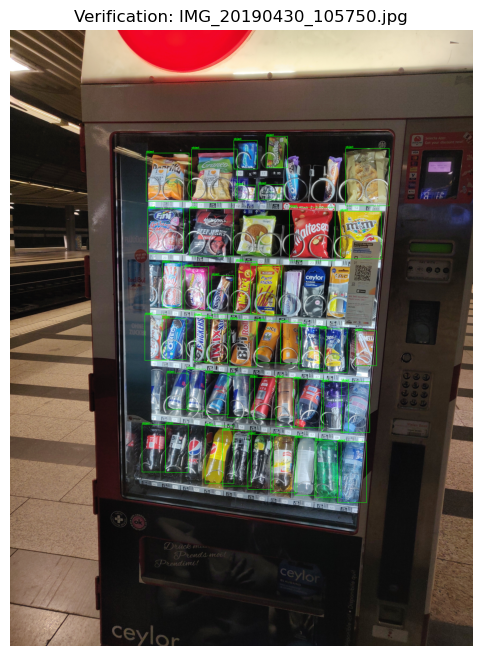

In [14]:
# Now verify with visualization
if class_names:
    print("\nVerifying conversion with sample image...\n")
    
    from pathlib import Path
    import cv2
    import matplotlib.pyplot as plt
    
    # Get first image to verify
    images_dir = Path(yolo_directory) / 'images'
    labels_dir = Path(yolo_directory) / 'labels'
    
    image_files = list(images_dir.glob('*.jpg')) + list(images_dir.glob('*.png'))
    
    if image_files:
        # Visualize first image
        img_path = image_files[0]
        label_path = labels_dir / f"{img_path.stem}.txt"
        
        # Read and display
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls_id = int(parts[0])
                x_center = float(parts[1]) * w
                y_center = float(parts[2]) * h
                width = float(parts[3]) * w
                height = float(parts[4]) * h
                
                x1 = int(x_center - width / 2)
                y1 = int(y_center - height / 2)
                x2 = int(x_center + width / 2)
                y2 = int(y_center + height / 2)
                
                class_name = class_names[cls_id]
                
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img, class_name, (x1, y1 - 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.title(f"Verification: {img_path.name}")
        plt.axis('off')
        plt.show()